In [17]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import matplotlib.pyplot as plt

# Using Selenium to download Zip file from website

In [18]:
def ChromeDriver(url):
    #the path for your chromedriver should be adjusted to your path
    driver = webdriver.Chrome(executable_path='C:\chromedriver.exe')
    driver.get(url)
    #time.sleep allows the brower to wait 5 seconds before returning
    time.sleep(5)
    return driver

link = "https://ga-covid19.ondemand.sas.com/docs/ga_covid_data.zip"
ChromeDriver(link)

<selenium.webdriver.chrome.webdriver.WebDriver (session="29fdb590e26c84459a233a5e58d9c9f3")>

# Unzip zip file and save demographics_sum.csv as a dataframe

In [19]:
#must be changed to users path for downloads
#you must check your files to make sure you don't already have a file from the past with same name
zf = zipfile.ZipFile(r"C:\Users\wjg39\Downloads\ga_covid_data.zip")

#ethnicity data
Georgia_ethnicity = pd.read_csv(zf.open('demographics_sum.csv')).groupby('Ethnicity').sum()

#race data
Georgia_demographics = pd.read_csv(zf.open('demographics_sum.csv'))
Georgia_demographics.drop(Georgia_demographics[Georgia_demographics.Ethnicity =='Hispanic/Latino'].index, inplace=True)
Georgia_race = Georgia_demographics.groupby('race').sum()
Georgia_race.loc["Hispanic"]=Georgia_ethnicity.loc["Hispanic/Latino"]

#summary data to find all cases and deaths
Georgia_summary = pd.read_csv(zf.open('summary_totals.csv'))

In [20]:
#reformatting so all column headers are on same row
Georgia_race.columns.name = Georgia_race.index.name
Georgia_race.index.name = None

Georgia_ethnicity.columns.name = Georgia_ethnicity.index.name
Georgia_ethnicity.index.name = None

# Georgia Summary, Race, and Ethnicity Dataframes

In [21]:
#Georgia summary is so you get see total cases, total deaths, and total tests. It also shows the date updated
Georgia_summary['Daily Status Report Date']=pd.to_datetime(Georgia_summary['Daily Status Report Date'], format='%d%b%Y')
Georgia_summary

,Daily Status Report Date,total_tests,cases,icu,hospitalization,deaths,antigen_cases,probable_deaths
0,2020-11-12,4375975,380190,6191,32947,8403,36686,478


In [22]:
Georgia_race

race,cases,Deaths
African-American/Black,104381,3317
American Indian/Alaska Native,202,10
Asian,6781,148
Native Hawaiian/Pacific Islander,351,6
Other,9471,17
Unknown,73447,60
White,137295,4331
Hispanic,48262,514


In [23]:
Georgia_ethnicity

Ethnicity,cases,Deaths
Hispanic/Latino,48262,514
Non-Hispanic/Latino,221445,7809
Unknown,110483,80


# Data Validation Check

In [24]:
#"Difference in sum of cases by race v. Total confirmed cases"
race_v_cases=int(Georgia_summary['cases'].sum()-Georgia_race['cases'].sum())

#"Difference in sum of cases by ethnicity v. Total confirmed cases"
race_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_race['Deaths'].sum())

#"Difference in sum of deaths by race v. Total confirmed deaths"
ethnicity_v_cases=int(Georgia_summary['cases'].sum()-Georgia_ethnicity['cases'].sum())

#"Difference in sum of deaths by ethnicity v. Total confirmed deaths"
ethnicity_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_ethnicity['Deaths'].sum())

data_validation= pd.DataFrame({"Difference in sum of cases by race v. Total confirmed cases":[race_v_cases], 
    "Difference in sum of deaths by race v. Total confirmed deaths":[race_v_deaths],
    "Difference in sum of cases by ethnicity v. Total confirmed cases":[ethnicity_v_cases],
    "Difference in sum of deaths by ethnicity v. Total confirmed deaths":[ethnicity_v_deaths]},index=['Data Validation']).T

#Red if values are not zero
data_validation.style.applymap(lambda x: 'background-color : red' if x!=0 else '')

,Data Validation
Difference in sum of cases by race v. Total confirmed cases,0
Difference in sum of deaths by race v. Total confirmed deaths,0
Difference in sum of cases by ethnicity v. Total confirmed cases,0
Difference in sum of deaths by ethnicity v. Total confirmed deaths,0


# Historical Georgia Data from CRDT Website

In [25]:
#get data from CRDT website
historical_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
df=pd.read_csv(historical_data)

#convert data column to datetime data-type
df['Date']= pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

#filter for Georgia data only and re-index
Georgia_Historical=df.loc[df['State']=='GA'].reset_index()
Georgia_Historical.drop('State', inplace=True, axis=1)
del Georgia_Historical['index']

#only display 5 most recent records (takes about 15 seconds to load)
Georgia_Historical.head(5)

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Hosp_LatinX,Hosp_Asian,Hosp_AIAN,Hosp_NHPI,Hosp_Multiracial,Hosp_Other,Hosp_Unknown,Hosp_Ethnicity_Hispanic,Hosp_Ethnicity_NonHispanic,Hosp_Ethnicity_Unknown
0,2020-11-11,377694,136298,103793.0,48026.0,6721.0,200.0,347.0,NaN,9417.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-08,373078,134087,102587.0,47530.0,6599.0,194.0,344.0,NaN,9310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-11-04,366452,130472,100553.0,46818.0,6452.0,192.0,342.0,NaN,9202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-01,361982,127516,99081.0,46298.0,6253.0,182.0,340.0,NaN,9173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-28,355025,123679,96677.0,45521.0,6071.0,181.0,333.0,NaN,9137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Converting New Scraped Covid Data into Same Format as CRDT Table 

In [26]:
column_names = ["Date","Cases_Total","Cases_White","Cases_Black","Cases_LatinX","Cases_Asian",
                "Cases_AIAN","Cases_NHPI","Cases_Multiracial","Cases_Other","Cases_Unknown",
                "Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown",
                "Deaths_Total","Deaths_White","Deaths_Black","Deaths_LatinX","Deaths_Asian",
               "Deaths_AIAN","Deaths_NHPI","Deaths_Multiracial","Deaths_Other","Deaths_Unknown",
               "Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]

#new_data is the dataframe for the new data which you just scraped converted into data format of Georgia_Historical
new_data = pd.DataFrame(columns = column_names)

new_data["Date"]=[Georgia_summary.loc[0,"Daily Status Report Date"]]
new_data["Cases_Total"]=[Georgia_summary.loc[0,"cases"]]
new_data["Cases_White"]=[Georgia_race.loc["White","cases"]]
new_data["Cases_Black"]=[Georgia_race.loc["African-American/Black","cases"]]
new_data["Cases_LatinX"]=[Georgia_race.loc["Hispanic","cases"]]
new_data["Cases_Asian"]=[Georgia_race.loc["Asian","cases"]]
new_data["Cases_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","cases"]]
new_data["Cases_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","cases"]]
new_data["Cases_Other"]=[Georgia_race.loc["Other","cases"]]
new_data["Cases_Unknown"]=[Georgia_race.loc["Unknown","cases"]]
new_data["Cases_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_Unknown"]=[Georgia_ethnicity.loc["Unknown","cases"]]

new_data["Deaths_Total"]=[Georgia_summary.loc[0,"deaths"]]
new_data["Deaths_White"]=[Georgia_race.loc["White","Deaths"]]
new_data["Deaths_Black"]=[Georgia_race.loc["African-American/Black","Deaths"]]
new_data["Deaths_LatinX"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Asian"]=[Georgia_race.loc["Asian","Deaths"]]
new_data["Deaths_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","Deaths"]]
new_data["Deaths_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","Deaths"]]
new_data["Deaths_Other"]=[Georgia_race.loc["Other","Deaths"]]
new_data["Deaths_Unknown"]=[Georgia_race.loc["Unknown","Deaths"]]
new_data["Deaths_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_Unknown"]=[Georgia_ethnicity.loc["Unknown","Deaths"]]

new_data

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-12,380190,137295,104381,48262,6781,202,351,NaN,9471,...,514,148,10,6,NaN,17,60,514,7809,80


# Appending the New Scraped Data to CRDT Georgia Historical Data

In [27]:
#Georgia_Last is the data from the CRDT GA Historical data which you want to compare with new scraped data in time series

#Because CRDT are every Wednesday and Sunday Night. 
#So if you are running the Scrpaer on a Wednesday or Sunday Night, 
    #there will be zero difference in new scraped data and historical data from CRDT
    #So I put the second most recent data for scrpaer to compare with as a way to avoid getting zero. 
    
Georgia_Last_Shift=Georgia_Historical.loc[[1]] #.loc[[0]] means most recent data in CRDT, .loc[[1]] second most recent data
#You should adjust the .loc[[0]] or .loc[[1]] depending on what day or time you are running the scaper.

#Append the new scraped data and historical data.
append_data=Georgia_Last_Shift.append(new_data, ignore_index=True)

#Set index as date and all datatype as a number. 
append_data.set_index('Date', inplace=True)
append_data=append_data.astype('float64')

append_data

,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,Cases_Unknown,...,Hosp_LatinX,Hosp_Asian,Hosp_AIAN,Hosp_NHPI,Hosp_Multiracial,Hosp_Other,Hosp_Unknown,Hosp_Ethnicity_Hispanic,Hosp_Ethnicity_NonHispanic,Hosp_Ethnicity_Unknown
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-08,373078.0,134087.0,102587.0,47530.0,6599.0,194.0,344.0,NaN,9310.0,72427.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-12,380190.0,137295.0,104381.0,48262.0,6781.0,202.0,351.0,NaN,9471.0,73447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Time Series Diffs Check (amount by which each category increased)

In [28]:
#This data quality checker is to simulate the first tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
diffs = append_data.diff().T

#Orange cells means the category has decreased
#Red cells decreased by more than 100
diffs.style.applymap(lambda x: 'background-color : orange' if x<0 and x>-100 else '').\
applymap(lambda x: 'background-color : red' if x<-100 or x==100 else '')

Date,2020-11-08 00:00:00,2020-11-12 00:00:00
Cases_Total,nan,7112.000000
Cases_White,nan,3208.000000
Cases_Black,nan,1794.000000
Cases_LatinX,nan,732.000000
Cases_Asian,nan,182.000000
Cases_AIAN,nan,8.000000
Cases_NHPI,nan,7.000000
Cases_Multiracial,nan,nan
Cases_Other,nan,161.000000
Cases_Unknown,nan,1020.000000


# Time Series %ofSelf  Check (percent by which each category has increased)

In [43]:
#This data quality checker is to simulate the second tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
#The *100 is to go from a decimal to a percentage
perc_diff = append_data.pct_change().T*100

#yellow >25%
#orange >50%
#red >100% doubles
perc_diff.style.applymap(lambda x: 'background-color : yellow' if abs(x)>25 and abs(x)<50 else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>50 and abs(x)<100 else '').\
applymap(lambda x: 'background-color : red' if abs(x)>100 else '')

Date,2020-11-08 00:00:00,2020-11-12 00:00:00
Cases_Total,nan,1.906304
Cases_White,nan,2.392477
Cases_Black,nan,1.748760
Cases_LatinX,nan,1.540080
Cases_Asian,nan,2.757994
Cases_AIAN,nan,4.123711
Cases_NHPI,nan,2.034884
Cases_Multiracial,nan,nan
Cases_Other,nan,1.729323
Cases_Unknown,nan,1.408315


# Time Series %ofTotal (percent by which percent-of-total that category increased)

In [41]:
#This data quality checker is to simulate the third tab of the Google Sheet used by CRDT for TimeSeries checks. 

#First have to divide up the append_data into 6 different dataframes(Total Cases, Race Cases, Ethnicity Cases...etc)
#Each of the six dataframes should sum up to either to total cases or total deaths. 
#Then can divide each category by the total sum of each category to find the percentage
#Then compare the percentage of total for each category with new data and last first to find percent_difference
#A simple example would be if Total Cases was 1000, then Hispanic cases 200, Non-Hispanic Cases are 500,
    #and unknown ethnicity was 300. Hispanic cases is 20%, Non-Hispanic Cases is 50%, and Unknown is 30%. 
    #then you would compare with the previous shift percentages to determine percentage change. 

#Total Cases
Cases_Total_PCT=append_data[['Cases_Total']].div(append_data[['Cases_Total']].sum(axis=1), axis=0)
Cases_Total_PCT=Cases_Total_PCT.pct_change()*100

#Race Cases
Cases_Race=append_data[['Cases_White','Cases_Black','Cases_LatinX','Cases_Asian','Cases_AIAN',
             'Cases_NHPI','Cases_Multiracial','Cases_Other','Cases_Unknown']]
Cases_Race_PCT = Cases_Race.div(Cases_Race.sum(axis=1), axis=0)
Cases_Race_PCT=Cases_Race_PCT.pct_change()*100

#Ethnicity Cases
Cases_Ethnicity=append_data[["Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown"]]
Cases_Ethnicity_PCT = Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)
Cases_Ethnicity_PCT=Cases_Ethnicity_PCT.pct_change()*100

#Total Deaths 
Deaths_Total_PCT=append_data[['Deaths_Total']].div(append_data[['Deaths_Total']].sum(axis=1), axis=0)
Deaths_Total_PCT=Deaths_Total_PCT.pct_change()*100

#Race Deaths
Deaths_Race=append_data[['Deaths_White','Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_AIAN',
             'Deaths_NHPI','Deaths_Multiracial','Deaths_Other','Deaths_Unknown']]
Deaths_Race_PCT = Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)
Deaths_Race_PCT=Deaths_Race_PCT.pct_change()*100

#Ethnicity Cases
Deaths_Ethnicity=append_data[["Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]]
Deaths_Ethnicity_PCT = Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)
Deaths_Ethnicity_PCT=Deaths_Ethnicity_PCT.pct_change()*100


Perc_Total=pd.concat([Cases_Total_PCT,Cases_Race_PCT,Cases_Ethnicity_PCT,Deaths_Total_PCT,
                         Deaths_Race_PCT,Deaths_Ethnicity_PCT], axis=1).T

#Yellow cells have changed by >10%
#Orange cells have changed by >25%
#Red cells have changed by >50%
#Green are new categorys (Have not attempted yet, in Georgia the only race which is not tracked is multiracial)
Perc_Total.style.applymap(lambda x: 'background-color : yellow' if x>10 and x<25 else '').\
applymap(lambda x: 'background-color : orange' if abs(x)>25 and abs(x)<50 else '').\
applymap(lambda x: 'background-color : red' if abs(x)>50 else '')

Date,2020-11-08 00:00:00,2020-11-12 00:00:00
Cases_Total,nan,0.000000
Cases_White,nan,0.477078
Cases_Black,nan,-0.154597
Cases_LatinX,nan,-0.359373
Cases_Asian,nan,0.835758
Cases_AIAN,nan,2.175928
Cases_NHPI,nan,0.126175
Cases_Multiracial,nan,nan
Cases_Other,nan,-0.173670
Cases_Unknown,nan,-0.488674


In [31]:
# Thinking about including a fourth time series check which is the fourth tab of CRDT time series checker 'Summary'

# CRDT Dashboard Changes

In [74]:
#percentage of cases
Cases_Race=append_data[['Cases_Black','Cases_LatinX','Cases_Asian','Cases_NHPI','Cases_AIAN','Cases_White','Cases_Other']]
Cases_Race_PCT = (Cases_Race.div(Cases_Race.sum(axis=1), axis=0)*100).round(1).T

Asian_population=435875
Black_population=3348754
Hispanic_population=1042642
White_population=5502156
NHPI_population=5811
AIAN_population=19850
Other_population=284917
Population=pd.DataFrame({"Percentage of population":[Black_population,Hispanic_population,Asian_population,NHPI_population,
                                    AIAN_population,White_population,Other_population]}).set_index(Cases_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
CRDT_cases=pd.concat([Perc_of_pop, Cases_Race_PCT], axis=1)
CRDT_cases

,Percentage of population,2020-11-08 00:00:00,2020-11-12 00:00:00
Cases_Black,31.5,34.1,34.0
Cases_LatinX,9.8,15.8,15.7
Cases_Asian,4.1,2.2,2.2
Cases_NHPI,0.1,0.1,0.1
Cases_AIAN,0.2,0.1,0.1
Cases_White,51.7,44.6,44.8
Cases_Other,2.7,3.1,3.1


In [73]:
#percentage of deaths
Deaths_Race=append_data[['Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_NHPI','Deaths_AIAN','Deaths_White','Deaths_Other']]
Deaths_Race_PCT = (Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)*100).round(1).T

Asian_population=435875
Black_population=3348754
Hispanic_population=1042642
White_population=5502156
NHPI_population=5811
AIAN_population=19850
Other_population=284917
Population=pd.DataFrame({"Percentage of population":[Black_population,Hispanic_population,Asian_population,NHPI_population,
                                    AIAN_population,White_population,Other_population]}).set_index(Deaths_Race_PCT.index)
Perc_of_pop=(Population.div(Population.sum(axis=0), axis=1)*100).round(1)
test=pd.concat([Perc_of_pop, Deaths_Race_PCT], axis=1)
test

,Percentage of population,2020-11-08 00:00:00,2020-11-12 00:00:00
Deaths_Black,31.5,40.0,39.8
Deaths_LatinX,9.8,6.0,6.2
Deaths_Asian,4.1,1.8,1.8
Deaths_NHPI,0.1,0.1,0.1
Deaths_AIAN,0.2,0.1,0.1
Deaths_White,51.7,51.9,51.9
Deaths_Other,2.7,0.2,0.2


# Per Capita Bar Chart: Cases per 100k people

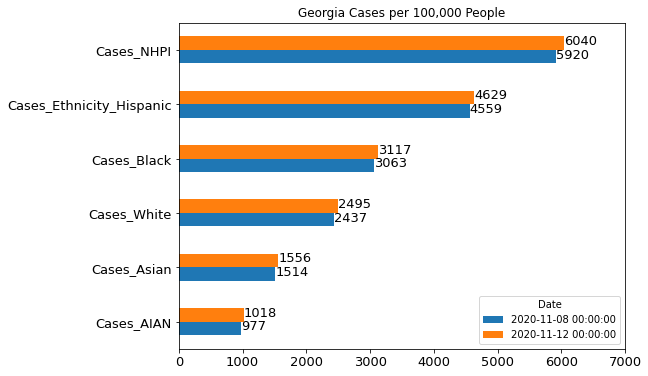

In [35]:
Asian_population=435875
Black_population=3348754
Hispanic_population=1042642
White_population=5502156
NHPI_population=5811
AIAN_population=19850

White_cases_per_cap=pd.DataFrame((append_data['Cases_White']/White_population*100000).round()).T
Black_cases_per_cap=pd.DataFrame((append_data['Cases_Black']/Black_population*100000).round()).T
Hispanic_cases_per_cap=pd.DataFrame((append_data['Cases_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_cases_per_cap=pd.DataFrame((append_data["Cases_Asian"]/Asian_population*100000).round()).T
NHPI_cases_per_cap=pd.DataFrame((append_data["Cases_NHPI"]/NHPI_population*100000).round()).T
AIAN_cases_per_cap=pd.DataFrame((append_data["Cases_AIAN"]/AIAN_population*100000).round()).T

Cases_per_cap=pd.concat([White_cases_per_cap, Black_cases_per_cap,Hispanic_cases_per_cap,Asian_cases_per_cap,
                        NHPI_cases_per_cap,AIAN_cases_per_cap], axis=0)
Cases_per_cap=Cases_per_cap.sort_values(Cases_per_cap.columns[1],ascending=True)
ax=Cases_per_cap.plot.barh(figsize=(8, 6),title="Georgia Cases per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,7000)

# Per Capita Bar Chart: Deaths per 100k people

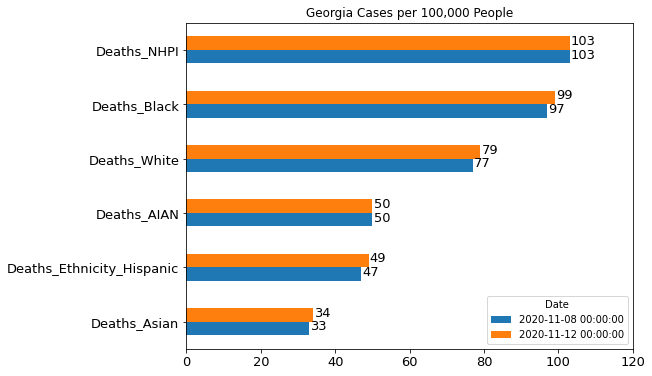

In [40]:
Asian_population=435875
Black_population=3348754
Hispanic_population=1042642
White_population=5502156
NHPI_population=5811
AIAN_population=19850

White_deaths_per_cap=pd.DataFrame((append_data['Deaths_White']/White_population*100000).round()).T
Black_deaths_per_cap=pd.DataFrame((append_data['Deaths_Black']/Black_population*100000).round()).T
Hispanic_deaths_per_cap=pd.DataFrame((append_data['Deaths_Ethnicity_Hispanic']/Hispanic_population*100000).round()).T
Asian_deaths_per_cap=pd.DataFrame((append_data["Deaths_Asian"]/Asian_population*100000).round()).T
NHPI_deaths_per_cap=pd.DataFrame((append_data["Deaths_NHPI"]/NHPI_population*100000).round()).T
AIAN_deaths_per_cap=pd.DataFrame((append_data["Deaths_AIAN"]/AIAN_population*100000).round()).T

Deaths_per_cap=pd.concat([White_deaths_per_cap, Black_deaths_per_cap,Hispanic_deaths_per_cap,Asian_deaths_per_cap,
                        NHPI_deaths_per_cap,AIAN_deaths_per_cap], axis=0)
Deaths_per_cap=Deaths_per_cap.sort_values(Cases_per_cap.columns[1],ascending=True)
ax=Deaths_per_cap.plot.barh(figsize=(8, 6),title="Georgia Deaths per 100,000 People",fontsize=13)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.1, \
            int((i.get_width())), fontsize=13,
color='black')

ax=ax.set_xlim(0,120)

# Testing Data Visualizations for Percent of Change

<AxesSubplot:title={'center':'White vs Black Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

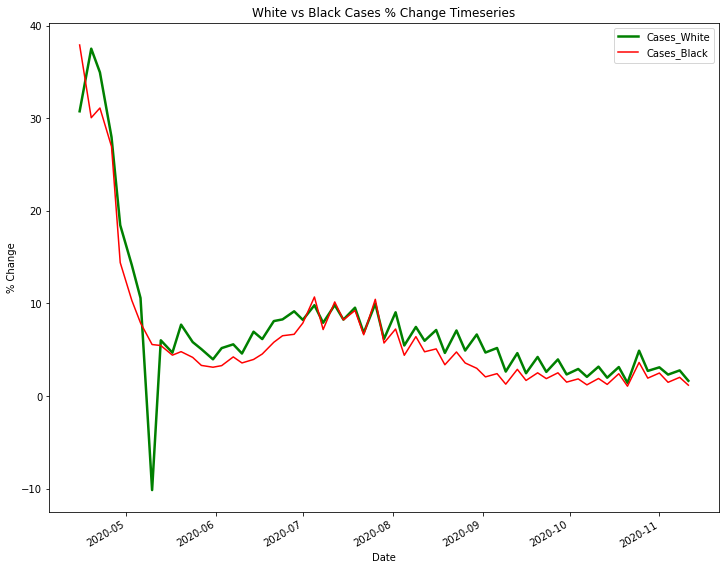

In [33]:
#Percent change for each CRDT data entry shift for White Cases vs Black Cases
cases_white = Georgia_Historical[['Date','Cases_White']].sort_values(by='Date')
cases_white.set_index('Date', inplace=True)
cases_white=cases_white.astype('float64')
cases_white_pct=cases_white.pct_change()*100

cases_black = Georgia_Historical[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

ax=cases_white_pct.plot(figsize=(12, 10), title='White vs Black Cases % Change Timeseries',linewidth=2.5, color='green'
                     ,ylabel='% Change',xlabel='Date')

cases_black_pct.plot(ax=ax, color='red')

<AxesSubplot:title={'center':'Black vs Asian Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

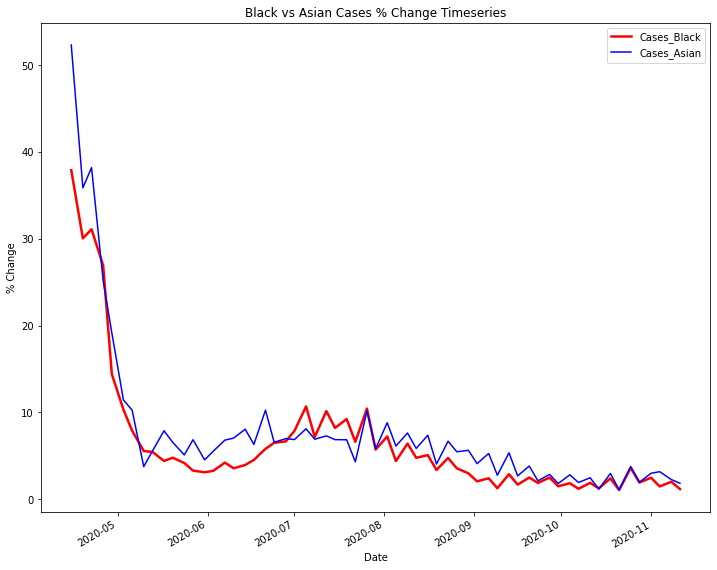

In [34]:
#Percent change for each CRDT data entry shift for Black Cases vs Asian Cases
cases_black = Georgia_Historical[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

cases_asian = Georgia_Historical[['Date','Cases_Asian']].sort_values(by='Date')
cases_asian.set_index('Date', inplace=True)
cases_asian=cases_asian.astype('float64')
cases_asian_pct=cases_asian.pct_change()*100

ax=cases_black_pct.plot(figsize=(12, 10), title='Black vs Asian Cases % Change Timeseries',linewidth=2.5, color='red'
                     ,ylabel='% Change',xlabel='Date')
cases_asian_pct.plot(ax=ax, color='blue')

# Summary Statistics for Percentage Change for Each Race and Ethnicity

In [24]:
Georgia_Historical_Sorted=Georgia_Historical.set_index('Date').sort_index()
Georgia_Historical_Sorted=Georgia_Historical_Sorted.astype('float64')
Georgia_Historical_PCT=Georgia_Historical_Sorted.pct_change()*100
Georgia_Historical_PCT.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Cases_Total,59.0,6.038371,6.905758,-13.523218,2.028223,4.418746,8.060545,41.148162
Cases_White,59.0,7.574050,7.852695,-10.149095,3.962838,5.829863,8.240578,37.504726
Cases_Black,59.0,6.523649,7.439850,1.065639,2.498299,4.403365,6.924974,37.905874
Cases_LatinX,59.0,13.891803,63.995537,0.000000,1.490137,4.122638,9.109275,494.014085
Cases_Asian,59.0,7.910620,9.041980,1.092511,3.775933,5.858055,7.342696,52.325581
Cases_AIAN,59.0,5.642079,10.920907,-21.951220,0.000000,2.777778,8.344349,47.826087
Cases_NHPI,59.0,8.737011,22.734116,-60.000000,1.931346,4.761905,13.006757,150.000000
Cases_Multiracial,59.0,inf,NaN,-100.000000,0.000000,0.000000,0.000000,inf
Cases_Other,59.0,inf,NaN,-100.000000,1.112711,4.175873,9.251871,inf
Cases_Unknown,59.0,4.276973,8.614246,-22.285546,-0.613500,1.284172,8.894547,31.417872


# Changing the name of the file on path to the current day 
# This closes the file and renames so only run when fully complete with scraping and data quality checks

In [16]:
import os
import datetime
#closes the zip file. 
zf.close()
Current_Date = datetime.datetime.today().strftime ('%d-%b-%Y')
os.rename(r"C:\Users\wjg39\Downloads\ga_covid_data.zip",r"C:\Users\wjg39\Downloads\ga_covid_data_" + str(Current_Date) + '.zip')

#if you get a FileNotFoundError, it is because python has already changed the name. 